In [1]:
import sys
sys.path.append('../')

from shopping_assistant.preprocessor import DataPreprocessor
import pandas as pd

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_colwidth', None)
print("✅ Libraries imported successfully!")

/Users/xenia/Desktop/Xenia/projects/shopping-assistant/notebooks/../shopping_assistant/preprocessor.py:26: SyntaxWarning: invalid escape sequence '\s'
  "grey":   ["grey","gray","charcoal","slate","graphite","silver","ash","stone","gunmetal", "anthra(?:\s+melange)?", "anthra", "darkslate", "glaze", "granite"],


✅ Libraries imported successfully!


In [2]:
raw_data_path = "../data/FashionDataset.csv"
preprocessor = DataPreprocessor(raw_data_path)
preprocessor.process()
preprocessor.save("../data/clean_fashion_data.csv")
df = preprocessor.processed_data

In [3]:
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)

print("\n# let's look at the nan values")
print(df.isna().sum())

if "category" in df.columns:
    print("\n# category value counts")
    print(df["category"].value_counts())
else:
    print("\n# category column not found")

print("\n# describe")
print(df.describe(include="all"))

Columns: ['details', 'sizes', 'mrp', 'sell_price', 'discount_pct', 'sizes', 'sizes_count', 'brand', 'category', 'color_family', 'product_type', 'price_range', 'product_id']
Shape: (29575, 13)

# let's look at the nan values
details            0
sizes              0
mrp             7025
sell_price         0
discount_pct    7025
sizes              0
sizes_count        0
brand              0
category           0
color_family    1232
product_type       0
price_range        0
product_id         0
dtype: int64

# category value counts
category
Western Wear            9975
Indian Wear             9975
Lingerie & Nightwear    3225
Footwear                2475
Watches                 1725
Jewellery               1725
Fragrance                475
Name: count, dtype: int64

# describe
                                                                                     details  \
count                                                                                  29575   
unique                 

product_type rows that are lists (sample):
[['dress'], ['dress'], ['top'], ['dress'], ['jeans'], ['jeans'], ['dress'], ['top'], ['dress'], ['top']]


/var/folders/16/llhhg9l57rb1b34k1cw39gx80000gn/T/ipykernel_87504/2766620157.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index.astype(str), palette="tab20")


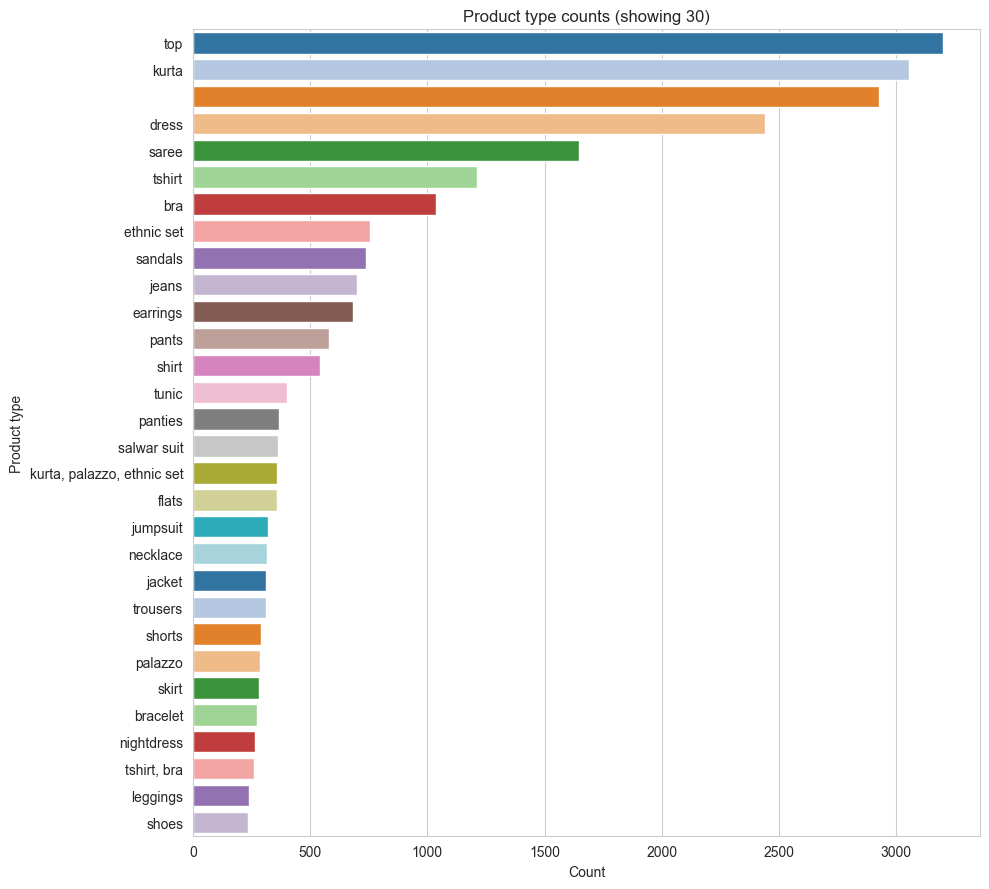

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# debug: show any rows where product_type is a list/tuple
mask_list = df["product_type"].apply(lambda x: isinstance(x, (list, tuple)))
if mask_list.any():
    print("product_type rows that are lists (sample):")
    print(df.loc[mask_list, "product_type"].head(10).to_list())

# coerce list/tuple entries to a comma-joined string, keep other values as str
product_series = df["product_type"].fillna("missing").apply(
    lambda x: ", ".join(x) if isinstance(x, (list, tuple)) else str(x)
)

counts = product_series.value_counts()
TOP_N = 30
top = counts.head(TOP_N) if counts.shape[0] > TOP_N else counts

plt.figure(figsize=(10, max(4, 0.3 * len(top))))
sns.barplot(x=top.values, y=top.index.astype(str), palette="tab20")
plt.xlabel("Count")
plt.ylabel("Product type")
plt.title(f"Product type counts (showing {len(top)})")
plt.tight_layout()
plt.show()

In [8]:
print("\n# categories with missing color_family")
df.loc[df["color_family"].isna(), "category"].value_counts()


# categories with missing color_family


category
Fragrance               381
Jewellery               286
Watches                 232
Lingerie & Nightwear    156
Footwear                 70
Western Wear             66
Indian Wear              41
Name: count, dtype: int64